In [25]:
# # # Install required libs
# !pip install -U segmentation-models-pytorch albumentations --user 

In [27]:
# !pip uninstall -y segmentation-models-pytorch

Found existing installation: segmentation-models-pytorch 0.3.3
Uninstalling segmentation-models-pytorch-0.3.3:
  Successfully uninstalled segmentation-models-pytorch-0.3.3


In [26]:
# pip uninstall albumentations -y

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image[:,:,:3])
    plt.show()

In [3]:
import numpy as np
# Load data from .npy files
train_images = np.load("/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment/data/train_img_256.npy")
train_masks = np.load("/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment/data/train_msk_256.npy")
val_images = np.load("/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment/data/val_img_256.npy")
val_masks = np.load("/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment/data/val_msk_256.npy")

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch

In [5]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['flood','sprinkler','other']
    
    def __init__(
            self, 
            images, 
            masks, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images = images
        self.masks = masks
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        # read data
        image = self.images[idx]
        mask = self.masks[idx][:,:,:3]
        mask = np.argmax(mask,axis=-1)
        # mask = np.expand_dims(mask, axis=-1)
        
    
        # Assuming 'image' and 'mask' are your input data NumPy arrays
        image = torch.tensor(image, dtype=torch.float32)  # Convert input image to torch tensor with float32 data type
        mask = torch.tensor(mask,dtype=torch.long)    # Convert input mask to torch tensor with float32 data type
        image = image.permute(2, 0, 1)
        # mask = mask.permute(2, 0, 1)
        # Convert PyTorch tensor to NumPy array

        
#         # apply augmentations
#         if self.augmentation:
#             sample = self.augmentation(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
        
# #         # apply preprocessing
#         if self.preprocessing:
#             sample = self.preprocessing(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
            
        return {'image': image, 'mask': mask}
        
    def __len__(self):
        return len(self.images)

In [6]:
# Lets look at data we have

dataset = Dataset(train_images, train_masks, classes=['flood'])

data = dataset[4] # get some sample
print(data['mask'].shape)
# visualize(
#     image=image, 
#     mask=mask.squeeze(),
# )

torch.Size([256, 256])


### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [7]:
import albumentations as albu

In [8]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        # # albu.AdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                # albu.CLAHE(p=1),
                # albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.RandomContrast(p=1),
                # albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [9]:
# #### Visualize resulted augmented images and masks

# augmented_dataset = Dataset(
#     train_images, 
#     train_masks,
#     augmentation=get_training_augmentation(), 
#     classes=['flood','sprinkler','other'],
# )

# # same image with different random transforms
# for i in range(3):
#     image, mask = dataset[1]
#     print(image.shape)
#     visualize(image=image[:,:,:], mask=mask)

## Create model and train

In [10]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torchgeo.models import ResNet50_Weights,resnet50
import timm
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from lightning.pytorch import Trainer

In [11]:
weights = ResNet50_Weights.LANDSAT_OLI_SR_SIMCLR

In [12]:
checkpoint_file = '/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment/lightning_logs/version_59656609/checkpoints/epoch=99-step=111200.ckpt'
checkpoint = torch.load(checkpoint_file)

In [80]:
model_state_dict = checkpoint['state_dict']

In [13]:
in_chans = weights.meta["in_chans"]
print(in_chans)
model = timm.create_model("resnet50", in_chans=in_chans, num_classes=3)
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

7


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [82]:
# 

In [16]:
CLASSES = ['flood','sprinkler','other']
train_dataset = Dataset(
    train_images, 
    train_masks, 
    classes=CLASSES
)

valid_dataset = Dataset(
    val_images, 
    val_masks, 
    classes=CLASSES
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=12)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
from torchgeo.trainers import SemanticSegmentationTask
task = SemanticSegmentationTask(
    model="unet",
    backbone="resnet50",
    weights=weights,
    in_channels=7,
    num_classes=3,
    loss="ce",
    ignore_index=None,
    lr=0.1,
    patience=6,
)
trainer = Trainer(default_root_dir="/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment",max_epochs=150,log_every_n_steps=2)

trainer.fit(model=task, train_dataloaders=train_loader,val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Unet             | 32.5 M
---------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.136   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 79.15 GiB of which 12.19 MiB is free. Process 647398 has 77.39 GiB memory in use. Including non-PyTorch memory, this process has 1.70 GiB memory in use. Of the allocated memory 1.20 GiB is allocated by PyTorch, and 7.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [86]:
trainer = Trainer(default_root_dir="/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment",max_epochs=50,log_every_n_steps=2)

trainer.fit(model=task, train_dataloaders=train_loader,val_dataloaders=valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Unet             | 32.5 M
---------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.136   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [40]:
trainer.fit(model=task, train_dataloaders=train_loader,val_dataloaders=valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Unet             | 32.5 M
---------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.136   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Exception ignored in atexit callback: <function dump_compile_times at 0x7f4758b83880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/utils.py", line 238, in dump_compile_times
    f1_scores=f1_score(y_true, y_pred,num_classes)
  File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/utils.py", line 225, in compile_times
    return recall[1]
  File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/utils.py", line 75, in tabulate
    # Example: Normalize img, one-hot encode mask
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1016, in get_code
  File "<frozen importlib._bootstrap_external>",

In [18]:
trainer.validate(model=task,dataloaders=valid_loader,ckpt_path ="last")

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:186: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_MulticlassAccuracy   │     0.527178168296814      │
│ val_MulticlassJaccardIndex │     0.3579375147819519     │
│          val_loss          │     1.0013023614883423     │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 1.0013023614883423,
  'val_MulticlassAccuracy': 0.527178168296814,
  'val_MulticlassJaccardIndex': 0.3579375147819519}]

In [21]:
preds=trainer.predict(model=task,dataloaders=valid_loader,ckpt_path ="last")

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:186: .predict(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [24]:
preds[0].shape

torch.Size([8, 3, 256, 256])

In [40]:
# preds[1].shape

IndexError: index 8 is out of bounds for dimension 0 with size 8

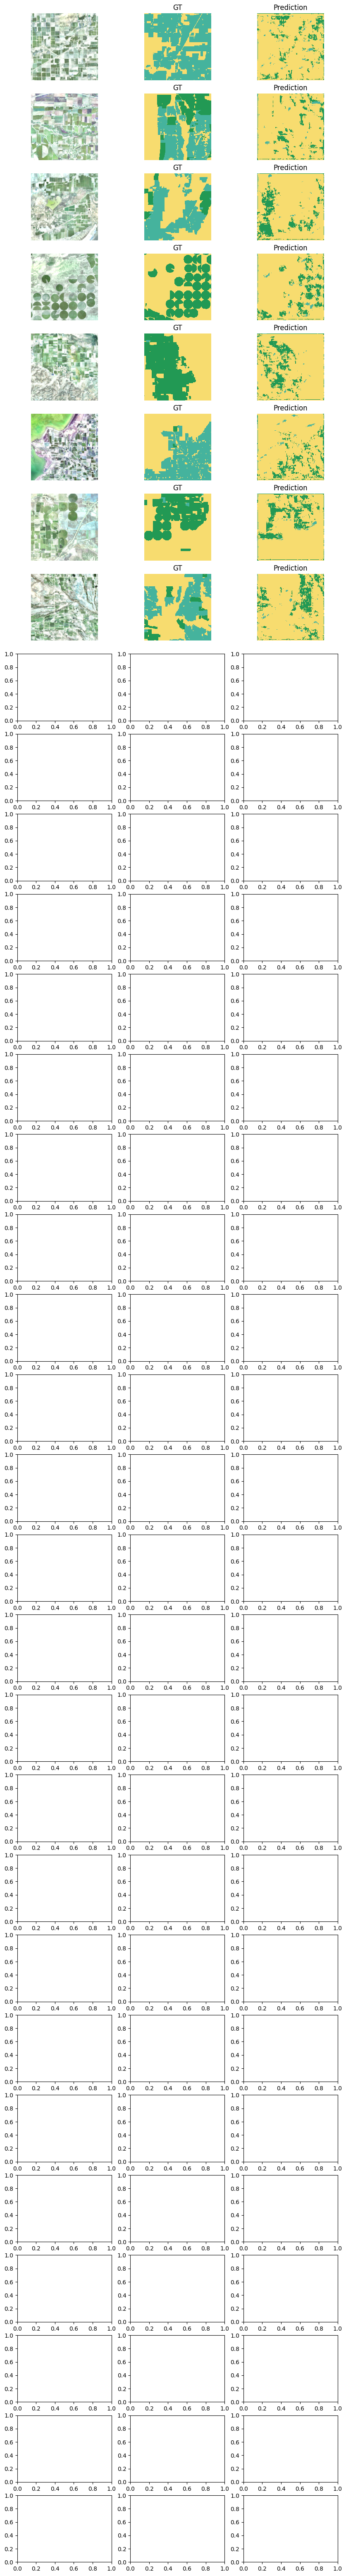

In [23]:
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
# Assuming model, valid_img_gen are defined, and weights are loaded
fig, axs = plt.subplots(32, 3, figsize=(10, 80))

# Define colors for each class, adjust as needed
class_colors = ['#45B39D', '#229954', '#F7DC6F','#145A32']  # Example for 3 classes
custom_cmap = ListedColormap(class_colors)
# Assuming your class labels are 0, 1, 2, etc., adjust boundaries accordingly
# Boundaries should cover all your class labels
class_labels = [0, 1, 2,3]  # Example for 3 classes, adjust as needed
# We add one more boundary than classes to ensure proper mapping
boundaries = np.arange(min(class_labels) - 0.5, max(class_labels) + 1.5, 1)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)
class_names = ['Flood','Sprinkler','NonIrr']

cnt = 0
legend_handles = [Patch(color=color, label=label) for color, label in zip(class_colors, class_names)]
i=0
for batch_idx, inputs in enumerate(valid_loader):

    images = inputs['image']
    labels  = inputs['mask']
    pred = preds[batch_idx]

    for j in range(32):
        
        image = images[j].numpy()
        image = image.transpose(2, 1, 0)
        label = labels[j].numpy()  # Adjusted for direct numpy conversion
        # print(image.shape)
        # label = label.transpose(2, 1, 0)
        masks = label
        pred_mask = pred[j].numpy().transpose(1,2,0)
        pred_mask = np.argmax(pred_mask, axis=-1)

        # Display the image
        axs[i][0].imshow(image[:, :, :3])
        # Display the true mask with custom colors
        axs[i][1].imshow(masks, cmap=custom_cmap, norm=norm, interpolation='nearest')
        # Display the predicted mask with custom colors
        axs[i][2].imshow(pred_mask, cmap=custom_cmap, norm=norm, interpolation='nearest')
        
        axs[i][1].set_title('GT')
        axs[i][2].set_title('Prediction')

        # Remove ticks
        axs[i][0].axis('off')
        axs[i][1].axis('off')
        axs[i][2].axis('off')
        
        i=i+1

    cnt = cnt+1
    break

# Add the legend at the top of the figure
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, .998), ncol=len(class_names))

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the bottom, top, left, right values as needed

plt.show()


In [ ]:
# Assuming `train_loader` is your DataLoader object
# Iterate over the first batch in the train_loader
for batch_idx, inputs in enumerate(train_loader):
    # Print the batch index
    print(f"Batch {batch_idx + 1}:")
    
    # Print the shape of input data (e.g., images)
    print("Input data shape:", inputs['image'].shape)
    
    # Print the shape of target data (e.g., labels or masks)
    print("Target data shape:", inputs['mask'].shape)
    
    y_true = trainer.prediinputs['mask'].view(8, 3, -1)
    print(y_true.shape)
    
    # Optionally, print or visualize some sample data from the batch
    # For example, you can print the first few elements of the input data and target data
    # print("Sample input data:", inputs[:5])
    # print("Sample target data:", targets[:5])
    
    # Break the loop after printing the first batch
    break


In [ ]:
from segmentation_models_pytorch import utils

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
DEVICE = 'cuda'
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )